In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import numpy as np


In [2]:
df = pd.read_csv("../2330.TW_data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[23:]
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-03,103.0,103.0,102.0,102.5,75.244667,38599000
2014-01-06,102.0,103.0,102.0,102.5,75.244667,23706000
2014-01-07,102.5,103.0,102.0,102.0,74.877609,15836000
2014-01-08,103.0,104.5,102.5,104.0,76.345802,30218000
2014-01-09,102.5,103.0,100.5,101.0,74.143509,63998000
...,...,...,...,...,...,...
2023-12-25,582.0,585.0,580.0,581.0,573.515503,9548143
2023-12-26,583.0,586.0,582.0,586.0,578.451111,16094308
2023-12-27,587.0,592.0,586.0,592.0,584.373840,33401336


In [3]:
from sklearn.preprocessing import MinMaxScaler

def preprocess(data_trend, train_ratio, n_past, predict_day):
    scaler = MinMaxScaler()  
    print(data_trend.shape)
    data_trend = scaler.fit_transform(data_trend)
    
    train_ind = int(len(data_trend) * train_ratio)
    train_data = data_trend[:train_ind]
    test_data = data_trend[train_ind:]

    # 產生序列資料
    X_train_full, Y_train_full = create_sequences(train_data, n_past, predict_day)
    X_test, Y_test = create_sequences(test_data, n_past, predict_day)

    val_ind = int(len(X_train_full) * test_val_ratio)
    X_train, X_val = X_train_full[:val_ind], X_train_full[val_ind:]
    Y_train, Y_val = Y_train_full[:val_ind], Y_train_full[val_ind:]

    return X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler



def create_sequences(data, n_past, predict_day):
    X, Y = [], []
    L = len(data)
    for i in range(L - (n_past + predict_day - 1)):
        X.append(data[i:i + n_past])  # 過去 n_past 天的資料
        Y.append(data[i + n_past:i + n_past + predict_day, 3])  # 預測未來 predict_day 天的目標變數
    return torch.Tensor(np.array(X)), torch.Tensor(np.array(Y))

data = df[[c for c in df.columns if c not in ['Date','Adj Close','Volume']]].values
train_ratio = 0.9
test_val_ratio = 0.9
n_past = 40     #移動視窗大小
predict_day = 10 #要預測後面幾天
X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler = preprocess(data, train_ratio, n_past, predict_day)
batch_size = 32

train_set = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False)

val_set = torch.utils.data.TensorDataset(X_val, Y_val)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

test_set = torch.utils.data.TensorDataset(X_test, Y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape) 
print(Y_test.shape)
print(X_val)

(2439, 4)
torch.Size([1931, 40, 4])
torch.Size([1931, 10])
torch.Size([215, 40, 4])
torch.Size([215, 10])
torch.Size([195, 40, 4])
torch.Size([195, 10])
tensor([[[0.8493, 0.8498, 0.8494, 0.8506],
         [0.8476, 0.8549, 0.8545, 0.8575],
         [0.8630, 0.8754, 0.8684, 0.8833],
         ...,
         [0.9298, 0.9283, 0.9290, 0.9279],
         [0.9212, 0.9437, 0.9290, 0.9485],
         [0.9281, 0.9266, 0.9307, 0.9279]],

        [[0.8476, 0.8549, 0.8545, 0.8575],
         [0.8630, 0.8754, 0.8684, 0.8833],
         [0.8784, 0.8737, 0.8753, 0.8712],
         ...,
         [0.9212, 0.9437, 0.9290, 0.9485],
         [0.9281, 0.9266, 0.9307, 0.9279],
         [0.9144, 0.9198, 0.9255, 0.9193]],

        [[0.8630, 0.8754, 0.8684, 0.8833],
         [0.8784, 0.8737, 0.8753, 0.8712],
         [0.8596, 0.8652, 0.8649, 0.8575],
         ...,
         [0.9281, 0.9266, 0.9307, 0.9279],
         [0.9144, 0.9198, 0.9255, 0.9193],
         [0.9298, 0.9249, 0.9186, 0.9176]],

        ...,

        [[0

In [4]:

class LSTM(nn.Module):
    def __init__(self, n_features, hidden_dim, predict_day):
        super(LSTM, self).__init__()
        self.n_features = n_features
        self.hidden_dim = hidden_dim
        self.predict_day = predict_day
        
        self.lstm = nn.LSTM(input_size=self.n_features, hidden_size=self.hidden_dim, 
                            num_layers=2, bidirectional=False, batch_first=True, dropout=0.2)
        self.linear = nn.Linear(self.hidden_dim, self.predict_day)
        
    def forward(self, x): 
        x, _ = self.lstm(x)
        x = self.linear(x[:,-1,:]) #取最後一個state
        
        return x


In [12]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
# 檢查是否有可用的GPU
if torch.cuda.is_available():
    print("GPU")
    device = torch.device("cuda")  # 使用GPU
else:
    print("CPU")
    device = torch.device("cpu")  # 使用CPU
# 設置訓練參數
num_epochs = 100
learning_rate = 0.001

# 初始化模型、損失函數和優化器
model = LSTM(n_features=4, hidden_dim=128, predict_day=10)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

GPU


In [13]:
# 記錄每個 epoch 的損失值
train_losses = []
val_losses = []
min_val_loss = float('inf')
best_model_path = "lstm_10.pth"

# 訓練模型
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for i, (x_batch, y_batch) in enumerate(train_loader):
        x_batch= x_batch.to(device)
        y_batch= y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    # 驗證模型
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(test_loader):
            x_batch= x_batch.to(device)
            y_batch= y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    '''
    if val_loss < min_val_loss and epoch>50:
        min_val_loss = val_loss
        torch.save(model, best_model_path) 
        print(f"Model saved with val_loss: {val_loss:.4f}")
    '''
    # 打印每個epoch的訓練和驗證損失
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    torch.save(model, best_model_path)



Epoch [1/100], Train Loss: 0.0089, Val Loss: 0.0046
Epoch [2/100], Train Loss: 0.0317, Val Loss: 0.0045
Epoch [3/100], Train Loss: 0.0820, Val Loss: 0.1089
Epoch [4/100], Train Loss: 0.1059, Val Loss: 0.0277
Epoch [5/100], Train Loss: 0.0210, Val Loss: 0.0010
Epoch [6/100], Train Loss: 0.0033, Val Loss: 0.0015
Epoch [7/100], Train Loss: 0.0020, Val Loss: 0.0051
Epoch [8/100], Train Loss: 0.0026, Val Loss: 0.0058
Epoch [9/100], Train Loss: 0.0010, Val Loss: 0.0012
Epoch [10/100], Train Loss: 0.0013, Val Loss: 0.0013
Epoch [11/100], Train Loss: 0.0023, Val Loss: 0.0046
Epoch [12/100], Train Loss: 0.0029, Val Loss: 0.0028
Epoch [13/100], Train Loss: 0.0048, Val Loss: 0.0019
Epoch [14/100], Train Loss: 0.0064, Val Loss: 0.0026
Epoch [15/100], Train Loss: 0.0068, Val Loss: 0.0051
Epoch [16/100], Train Loss: 0.0052, Val Loss: 0.0239
Epoch [17/100], Train Loss: 0.0013, Val Loss: 0.0041
Epoch [18/100], Train Loss: 0.0027, Val Loss: 0.0020
Epoch [19/100], Train Loss: 0.0037, Val Loss: 0.0007
Ep

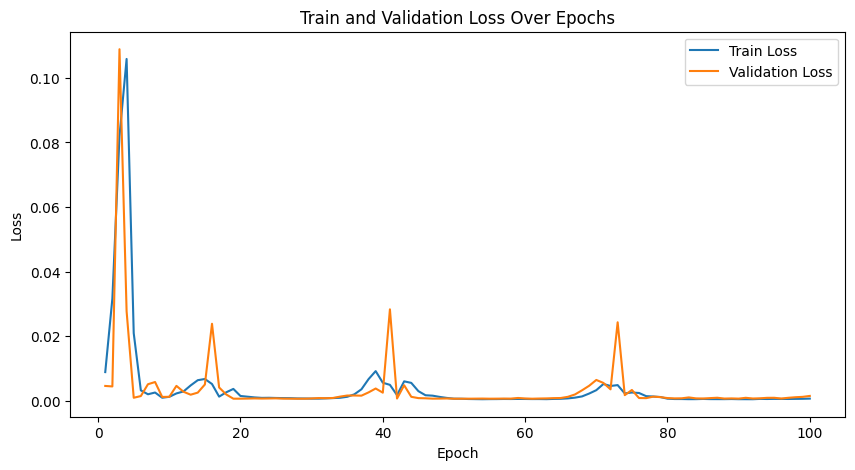

In [14]:
import matplotlib.pyplot as plt
# 繪製損失走勢圖
plt.figure(figsize=(10, 5))
plt.plot(range(1, 100+1), train_losses, label='Train Loss')
plt.plot(range(1, 100+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss Over Epochs')
plt.show()

In [15]:
print(len(Y_test))
close_price_true = []
temp_real = []
real = Y_test.detach().cpu().numpy()
for i in range(len(Y_test)):
   temp_real.append(real[i][0])
temp_real = np.array(temp_real)
temp_real = temp_real.reshape(-1, 1)
temp_real = np.repeat(temp_real, 4, axis=1)
# print(close_price_true)
temp_real = scaler.inverse_transform(temp_real)
# print(temp_real)
for i in range(len(temp_real)):
   close_price_true.append(temp_real[i][3])
print(close_price_true)


195
[524.0, 521.0, 522.0, 513.0, 516.0, 510.0, 511.0, 505.0, 518.0, 512.0, 517.0, 533.0, 538.0, 539.0, 531.0, 525.0, 530.0, 535.0, 533.0, 530.0, 531.0, 529.0, 524.0, 520.0, 510.0, 516.0, 520.0, 515.0, 510.0, 513.0, 511.0, 507.00003, 498.0, 491.5, 493.5, 502.0, 501.0, 496.00003, 498.0, 500.0, 504.0, 510.0, 503.0, 499.0, 496.00003, 495.50003, 505.0, 519.0, 530.0, 532.0, 531.0, 530.0, 525.0, 543.0, 566.0, 568.0, 566.0, 558.0, 551.0, 562.0, 555.0, 560.0, 568.0, 559.0, 565.0, 574.0, 593.0, 590.0, 591.0, 589.0, 582.99994, 582.99994, 581.0, 574.0, 572.0, 574.0, 573.0, 576.0, 579.0, 584.99994, 582.0, 565.0, 565.0, 565.0, 577.0, 578.0, 584.99994, 591.0, 591.0, 581.0, 581.0, 579.0, 560.0, 558.0, 569.0, 566.0, 569.0, 567.0, 565.0, 567.0, 561.0, 554.0, 558.0, 552.0, 554.0, 551.0, 546.0, 541.0, 542.0, 542.0, 544.0, 539.0, 537.0, 541.0, 552.0, 564.0, 546.0, 549.0, 552.0, 555.0, 549.0, 548.0, 557.0, 552.0, 550.0, 542.0, 539.0, 536.0, 544.0, 541.0, 550.0, 558.0, 540.0, 538.0, 535.0, 527.0, 522.0, 525.

[495.24533, 496.5041, 496.41135, 497.70712, 493.9983, 491.9701, 489.85742, 489.5225, 486.1075, 488.71542, 489.33716, 489.86804, 496.14075, 501.74667, 506.35333, 506.8159, 504.1751, 504.97903, 507.8648, 509.73312, 507.99585, 508.47067, 508.23154, 505.11374, 502.0563, 496.91965, 495.52533, 495.75098, 494.93564, 492.68063, 490.9874, 491.14328, 487.2796, 482.42316, 476.7239, 472.39267, 473.8565, 474.5361, 472.6581, 471.94998, 472.84903, 476.0865, 478.75394, 478.3898, 476.98584, 473.74493, 472.06317, 474.8191, 480.87564, 492.08685, 498.57355, 500.99826, 501.5429, 500.94754, 508.14697, 523.0074, 532.18896, 535.0792, 533.803, 531.3219, 534.6173, 535.5283, 535.9212, 539.09467, 539.52106, 540.77936, 545.63226, 555.71814, 559.61914, 562.0415, 563.0716, 562.42377, 561.8979, 562.01636, 560.07837, 557.62775, 558.05646, 558.0171, 556.8229, 558.27875, 561.02484, 562.63403, 557.5159, 554.01746, 552.9543, 555.0371, 556.2074, 560.7839, 563.9567, 565.4121, 564.3524, 563.72864, 562.81287, 554.8811, 550.48

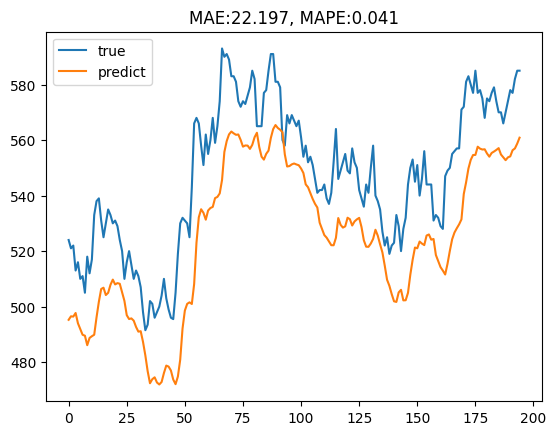

In [16]:
# model = torch.load("model.pt")
# len(test_set)
import matplotlib.pyplot as plt
close_price_pred = []
model = torch.load('lstm_10.pth')
model.to(device)
for i in range(len(test_set)):
    x,y = test_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred = model(x.to(device))
    pred = pred.detach().cpu().numpy()[0]
    pred = pred.reshape(-1, 1)
    # print(pred)
    pred = np.repeat(pred, 4, axis=1)
    pred_inver = scaler.inverse_transform(pred)
    # print(pred_inver[0][0])
    close_price_pred.append(pred_inver[0][3])
print(close_price_pred)
mape = np.mean(np.absolute(np.array(close_price_true) - np.array(close_price_pred))/np.array(close_price_true))
mae =  np.mean( np.absolute(np.array(close_price_true) - np.array(close_price_pred)))
plt.plot(close_price_true)
plt.plot(close_price_pred)
plt.title('MAE:{:.3f}, MAPE:{:.3f}'.format(mae, mape))
plt.legend(['true', 'predict'])

In [17]:
def preprocess(data_trend, train_ratio, n_past, predict_day):     
    train_ind = int(len(data_trend) * train_ratio)
    train_data = data_trend[:train_ind]
    test_data = data_trend[train_ind:]

    # 產生序列資料
    X_train_full, Y_train_full = create_sequences(train_data, n_past, predict_day)
    X_test, Y_test = create_sequences(test_data, n_past, predict_day)

    val_ind = int(len(X_train_full) * test_val_ratio)
    X_train, X_val = X_train_full[:val_ind], X_train_full[val_ind:]
    Y_train, Y_val = Y_train_full[:val_ind], Y_train_full[val_ind:]

    return X_train, Y_train, X_val, Y_val, X_test, Y_test



def create_sequences(data, n_past, predict_day):
    X, Y = [], []
    L = len(data)
    for i in range(L - (n_past + predict_day - 1)):
        X.append(data[i:i + n_past])  # 過去 n_past 天的資料
        Y.append(data[i + n_past:i + n_past + predict_day, 3])  # 預測未來 predict_day 天的目標變數
    return torch.Tensor(np.array(X)), torch.Tensor(np.array(Y))

data2 = df[[c for c in df.columns if c not in ['Date','Adj Close','Volume']]].values
X_train, Y_train, X_val, Y_val, X_test, Y_test = preprocess(data2, train_ratio, n_past, predict_day)
Y_test.shape

torch.Size([195, 10])

In [18]:
print(Y_test.shape)
pred_arr = []
#len(test_set)
arr = []
for i in range(len(test_set)):
    x,y = test_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred = model(x.to(device))
    pred = pred.detach().cpu().numpy()
    pred = pred.reshape(-1, 1)
    pred = np.repeat(pred, 4, axis=1)
    # print(pred)
    pred_inver = scaler.inverse_transform(pred)
    # print(pred_inver[:, 3])
    pred_arr.append(pred_inver[:, 3])
pred_arr = np.array(pred_arr)
pred_arr = torch.tensor(pred_arr)
print(pred_arr)
print(pred_arr[:,9].shape)
print(Y_test[:,9].shape)

torch.Size([195, 10])
tensor([[495.2453, 496.1208, 498.7764,  ..., 509.7921, 510.6671, 513.7085],
        [496.5041, 497.3781, 500.0143,  ..., 510.9067, 511.7863, 514.8259],
        [496.4113, 497.3450, 499.8832,  ..., 510.8615, 511.7361, 514.7798],
        ...,
        [556.9769, 558.3982, 559.6426,  ..., 566.2860, 567.3411, 569.1773],
        [558.7404, 560.1360, 561.3922,  ..., 567.7870, 568.8259, 570.6508],
        [560.8608, 562.1585, 563.4047,  ..., 569.4996, 570.5659, 572.3694]])
torch.Size([195])
torch.Size([195])


In [19]:
mae = torch.mean(torch.abs(pred_arr - Y_test))
mape = torch.mean(torch.abs(pred_arr - Y_test)/Y_test)
print(f"mae: {mae.item()}")
print(f"mape: {mape.item()}")

mae: 18.741901397705078
mape: 0.033949416130781174


In [15]:
ma10_f=[]
true=[]
pred=[]
pred_arr = np.array(pred_arr)
Y_test = np.array(Y_test)
for i in range(0,len(pred_arr)):
    true.append(Y_test[i][0])
    ma10_f.append(np.mean(pred_arr[i]))
    pred.append(pred_arr[i][0])
newdf = pd.DataFrame({'True':true, 'Pred':pred, 'MA10_F':ma10_f})
newdf

,True,Pred,MA10_F
0,524.0,539.339844,546.231262
1,521.0,540.887878,547.604004
2,522.0,541.285767,548.015137
3,513.0,542.471130,549.100769
4,516.0,539.888489,546.804626
...,...,...,...
190,578.0,586.562256,590.677856
191,577.0,588.166870,592.105103
192,582.0,588.993225,592.782166
193,585.0,589.878479,593.612671


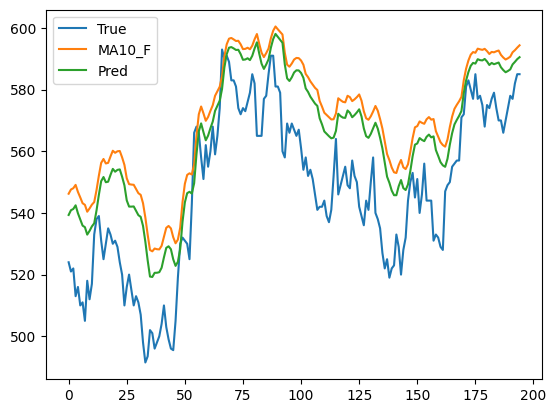

In [16]:
plt.plot(newdf['True'])
plt.plot(newdf['MA10_F'])
plt.plot(newdf['Pred'])
plt.legend(['True','MA10_F','Pred'])

In [17]:
cash=1000000 #初始資金100w
position=0 #持倉
buy_flag=0
def mothod(true, ma10_f, cash, position, buy_flag):
    income=[]
    buy_flag_arr=[]
    for i in range(1, len(true)):
        if i==0:
            cash=1000000
        elif i==len(true)-1 and position==1:
            cash=cash+position*true[i-1]*1000 #賣
            position=0
            buy_flag=-1
        else:
            if (ma10_f[i]-true[i-1])>=0 and position==0: #預測漲且沒有持倉
                position=1 #買
                entry_price = true[i-1]
                cash=cash-position*entry_price*1000
                buy_flag=1
            elif (ma10_f[i]-true[i-1])<0 and position==1:
                cash=cash+position*true[i-1]*1000 #賣
                position=0
                buy_flag=-1
            else:
                buy_flag=0
        print(i,cash,buy_flag)
        income.append(cash)
        buy_flag_arr.append(buy_flag)
    return income,buy_flag_arr
        # print(position)


money, buy_flag_arr = mothod(newdf['True'], newdf['MA10_F'], cash, position, buy_flag)

1 476000.0 1
2 476000.0 0
3 476000.0 0
4 476000.0 0
5 476000.0 0
6 476000.0 0
7 476000.0 0
8 476000.0 0
9 476000.0 0
10 476000.0 0
11 476000.0 0
12 476000.0 0
13 476000.0 0
14 476000.0 0
15 476000.0 0
16 476000.0 0
17 476000.0 0
18 476000.0 0
19 476000.0 0
20 476000.0 0
21 476000.0 0
22 476000.0 0
23 476000.0 0
24 476000.0 0
25 476000.0 0
26 476000.0 0
27 476000.0 0
28 476000.0 0
29 476000.0 0
30 476000.0 0
31 476000.0 0
32 476000.0 0
33 476000.0 0
34 476000.0 0
35 476000.0 0
36 476000.0 0
37 476000.0 0
38 476000.0 0
39 476000.0 0
40 476000.0 0
41 476000.0 0
42 476000.0 0
43 476000.0 0
44 476000.0 0
45 476000.0 0
46 476000.0 0
47 476000.0 0
48 476000.0 0
49 476000.0 0
50 476000.0 0
51 476000.0 0
52 476000.0 0
53 476000.0 0
54 476000.0 0
55 1042000.0 -1
56 474000.0 1
57 474000.0 0
58 474000.0 0
59 474000.0 0
60 474000.0 0
61 474000.0 0
62 474000.0 0
63 474000.0 0
64 474000.0 0
65 474000.0 0
66 474000.0 0
67 1067000.0 -1
68 477000.0 1
69 477000.0 0
70 477000.0 0
71 477000.0 0
72 477000.0

In [18]:
cash=1000000 #初始資金100w
position=0 #持倉
buy_flag=0
def mothod(true, pred, cash, position, buy_flag):
    income=[]
    buy_flag_arr=[]
    for i in range(1, len(true)):
        if i==0:
            cash=1000000
        elif i==len(true)-1 and position==1:
            cash=cash+position*true[i-1]*1000 #賣
            position=0
            buy_flag=-1
        else:
            if (pred[i]-true[i-1])>=0 and position==0: #預測漲且沒有持倉
                position=1 #買
                entry_price = true[i-1]
                cash=cash-position*entry_price*1000
                buy_flag=1
            elif (pred[i]-true[i-1])<0 and position==1:
                cash=cash+position*true[i-1]*1000 #賣
                position=0
                buy_flag=-1
            else:
                buy_flag=0
        print(i,cash,buy_flag)
        income.append(cash)
        buy_flag_arr.append(buy_flag)
    return income,buy_flag_arr
        # print(position)


money, buy_flag_arr = mothod(newdf['True'], newdf['Pred'], cash, position, buy_flag)

1 476000.0 1
2 476000.0 0
3 476000.0 0
4 476000.0 0
5 476000.0 0
6 476000.0 0
7 476000.0 0
8 476000.0 0
9 476000.0 0
10 476000.0 0
11 476000.0 0
12 476000.0 0
13 476000.0 0
14 476000.0 0
15 476000.0 0
16 476000.0 0
17 476000.0 0
18 476000.0 0
19 476000.0 0
20 476000.0 0
21 476000.0 0
22 476000.0 0
23 476000.0 0
24 476000.0 0
25 476000.0 0
26 476000.0 0
27 476000.0 0
28 476000.0 0
29 476000.0 0
30 476000.0 0
31 476000.0 0
32 476000.0 0
33 476000.0 0
34 476000.0 0
35 476000.0 0
36 476000.0 0
37 476000.0 0
38 476000.0 0
39 476000.0 0
40 476000.0 0
41 476000.0 0
42 476000.0 0
43 476000.0 0
44 476000.0 0
45 476000.0 0
46 476000.0 0
47 476000.0 0
48 476000.0 0
49 476000.0 0
50 476000.0 0
51 476000.0 0
52 476000.0 0
53 476000.0 0
54 476000.0 0
55 1042000.0 -1
56 1042000.0 0
57 476000.0 1
58 476000.0 0
59 476000.0 0
60 476000.0 0
61 476000.0 0
62 476000.0 0
63 476000.0 0
64 476000.0 0
65 476000.0 0
66 476000.0 0
67 1069000.0 -1
68 479000.0 1
69 479000.0 0
70 479000.0 0
71 479000.0 0
72 479000.

In [11]:

mae = torch.mean(torch.abs(pred_arr[:,9] - Y_test[:,9]))
mape = torch.mean(torch.abs(pred_arr[:,9] - Y_test[:,9])/Y_test[:,9])
print(f"mae: {mae.item()}")
print(f"mape: {mape.item()}")

mae: 27.05198860168457
mape: 0.05034302920103073


In [12]:
import csv

csv_filename = 'ex2output.csv'

# 將 Tensor 的值存入 CSV 檔案的第 A 行
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    # 每個值分別寫入每一行
    for value in Y_test[:,0].tolist():
        writer.writerow([value])

print(f"Tensor 已成功存入 {csv_filename} 的每一行！")

# 讀取已經存在的 CSV 檔案，將 Tensor B 的值加到第 A 行右邊的對應行
with open(csv_filename, mode='r', newline='') as file:
    reader = csv.reader(file)
    rows = list(reader)

# 把 Tensor B 的每個元素加到對應行的右邊
for i, value in enumerate(pred_arr[:,0].tolist()):
    rows[i].append(value)

# 寫回更新過的資料
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(rows)

print("Tensor B 的每個值已成功加到對應行右邊！")



Tensor 已成功存入 ex2output.csv 的每一行！
Tensor B 的每個值已成功加到對應行右邊！
